In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
import cv2
import numpy as np
import torch.nn.functional as F
import torch
from PIL import ImageOps
from PIL.Image import Image
from sympy.physics.control.control_plots import plt
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Subset

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:

def isgray(AB):
    A= AB[:, :, 0]
    B= AB[:, :, 1]
    
    if np.all(A == 128) and np.all(B == 128):
        return True
    else:
        return False
#         plt.figure(figsize=(2,2))
# #         plt.subplot(12,12,i+1)
#         plt.title('output')
#         plt.imshow(intput_image)

In [2]:
def isgray(AB):
    A= AB[:, :, 0]
    B= AB[:, :, 1]
    
    if np.all(A == 128) and np.all(B == 128):
        return True
    else:
        return False
ab_path = "/kaggle/input/image-colorization/ab/ab/ab1.npy"
l_path = "/kaggle/input/image-colorization/l/gray_scale.npy"
ab_df = np.load(ab_path)[0:10000]
L_df = np.load(l_path)[0:10000]
dataset = (L_df,ab_df )
color_indices = [i for i, AB in enumerate(dataset[1]) if not isgray(AB)]
dataset = (dataset[0][color_indices], dataset[1][color_indices])

# In kích thước mới của dataset
print("Kích thước dataset sau khi lọc: ", dataset[0].shape)

Kích thước dataset sau khi lọc:  (9206, 224, 224)


In [3]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset[0])
    
    def __getitem__(self, idx):
        L = np.array(dataset[0][idx]).reshape((224,224,1))
        L = L.astype(np.float32)/127.5 - 1.0
        L = transforms.ToTensor()(L)
#         print('L',L.shape)
        ab = np.array(dataset[1][idx])
#         print('abpre',ab.shape)
        ab = ab.astype(np.float32)/127.5 - 1.0
        ab = transforms.ToTensor()(ab)
#         print('abtensor',ab.shape)

        return L, ab

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        else:
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class ColorizationModel(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(ColorizationModel, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(1, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationModel().to(device)
# checkpoint = torch.load('/kaggle/working/colorization_model_9.pth')
# model.load_state_dict(checkpoint['model_state_dict'])

# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
learning_rate = 0.0001
batch_size = 32
num_epochs = 1000
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_size = int(0.8 * len(ColorizationDataset(dataset)))
print(train_size)
test_size = len(ColorizationDataset(dataset)) - train_size
print(test_size)
train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))

train_dataset = Subset(ColorizationDataset(dataset), train_indices)
test_dataset = Subset(ColorizationDataset(dataset), test_indices)


# train_dataset, test_dataset = torch.utils.data.random_split(ColorizationDataset(dataset), [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
# # Chia tập dữ liệu thành train và test với tỉ lệ 8:2
# train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# # Xây dựng DataLoader cho tập huấn luyện
# train_dataset = ColorizationDataset(train_df)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# # Xây dựng DataLoader cho tập kiểm tra
# test_dataset = ColorizationDataset(test_df)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


4000
1000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001
batch_size = 32
num_epochs = 1000
criterion = nn.L1Loss()
model = ColorizationModel().to(device)
checkpoint = torch.load('/kaggle/input/model40h/colorization_model_17.pth')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizer = checkpoint['optimizer_state_dict']
loss = checkpoint['loss']
print(f"Epoch: {L_epoch}")
print(f"Loss: {loss}")
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))

# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)






train_size = int(0.8 * len(ColorizationDataset(dataset)))
print(train_size)
test_size = len(ColorizationDataset(dataset)) - train_size
print(test_size)
train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))

train_dataset = Subset(ColorizationDataset(dataset), train_indices)
test_dataset = Subset(ColorizationDataset(dataset), test_indices)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
# # Chia tập dữ liệu thành train và test với tỉ lệ 8:2
# train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# # Xây dựng DataLoader cho tập huấn luyện
# train_dataset = ColorizationDataset(train_df)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# # Xây dựng DataLoader cho tập kiểm tra
# test_dataset = ColorizationDataset(test_df)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


Epoch: 899
Loss: 0.07258102297782898
7364
1842


In [7]:
# Train model

for epoch in range(L_epoch, num_epochs):
# for epoch in range(num_epochs):
# for epoch in range(num_epochs):    
    # Train on batches
    train_loss = 0
    for L, AB in train_loader:
        L=L.to(device)
        AB=AB.to(device)
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(L)

        # Compute loss
        loss = criterion(outputs, AB)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update train loss
        train_loss += loss.item()

    # Compute validation loss
    val_loss = 0
    with torch.no_grad():
        for L, AB in test_loader:
            L=L.to(device)
            AB=AB.to(device)
            # Forward pass
            outputs = model(L)

            # Compute loss
            loss = criterion(outputs, AB)

            # Update validation loss
            val_loss += loss.item()

    # Print loss
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
    if (epoch+1)%50 ==0:
        checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }
        save_path = f'colorization_model_{epoch//50}.pth'

        torch.save(checkpoint, save_path)
torch.save(model.state_dict(), 'colorization_model.pth')

Epoch 700/1000, Train Loss: 0.0159, Validation Loss: 0.0818
Epoch 701/1000, Train Loss: 0.0158, Validation Loss: 0.0817
Epoch 702/1000, Train Loss: 0.0158, Validation Loss: 0.0821
Epoch 703/1000, Train Loss: 0.0159, Validation Loss: 0.0818
Epoch 704/1000, Train Loss: 0.0160, Validation Loss: 0.0818
Epoch 705/1000, Train Loss: 0.0160, Validation Loss: 0.0821
Epoch 706/1000, Train Loss: 0.0159, Validation Loss: 0.0818
Epoch 707/1000, Train Loss: 0.0158, Validation Loss: 0.0817
Epoch 708/1000, Train Loss: 0.0161, Validation Loss: 0.0818
Epoch 709/1000, Train Loss: 0.0157, Validation Loss: 0.0819
Epoch 710/1000, Train Loss: 0.0157, Validation Loss: 0.0818
Epoch 711/1000, Train Loss: 0.0159, Validation Loss: 0.0826
Epoch 712/1000, Train Loss: 0.0165, Validation Loss: 0.0823
Epoch 713/1000, Train Loss: 0.0162, Validation Loss: 0.0822
Epoch 714/1000, Train Loss: 0.0160, Validation Loss: 0.0820
Epoch 715/1000, Train Loss: 0.0159, Validation Loss: 0.0816
Epoch 716/1000, Train Loss: 0.0159, Vali

KeyboardInterrupt: 

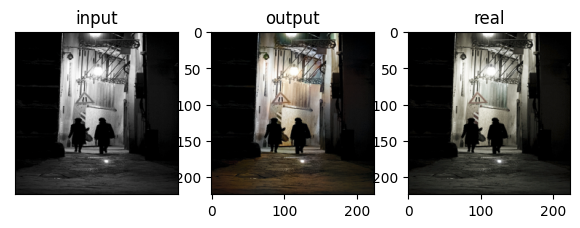

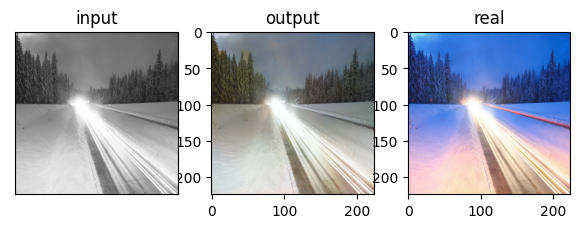

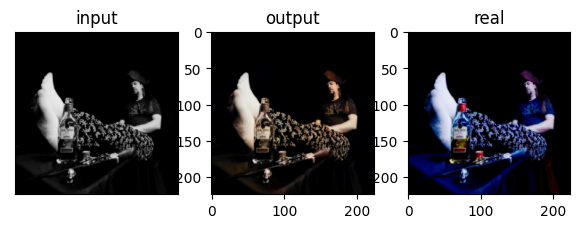

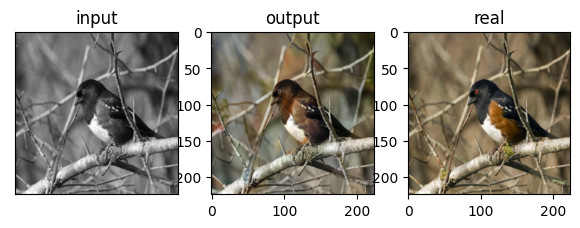

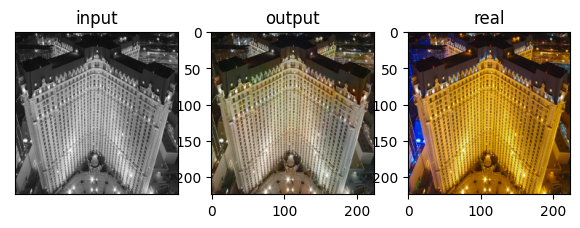

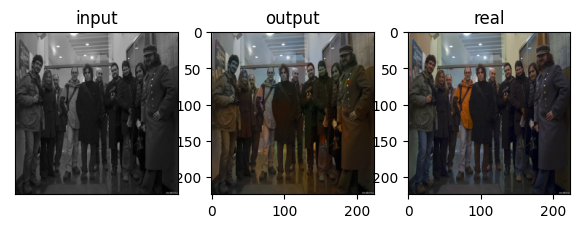

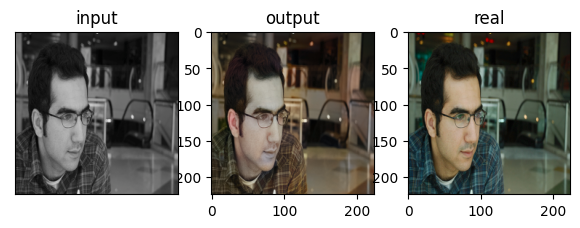

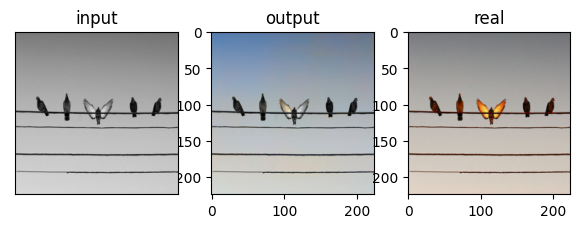

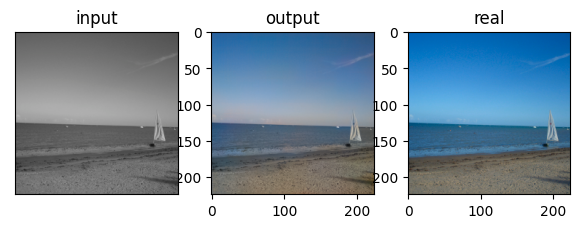

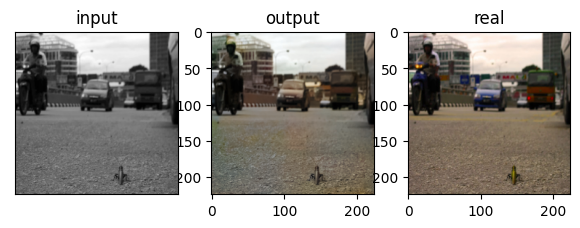

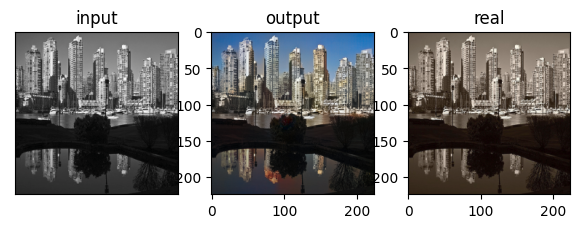

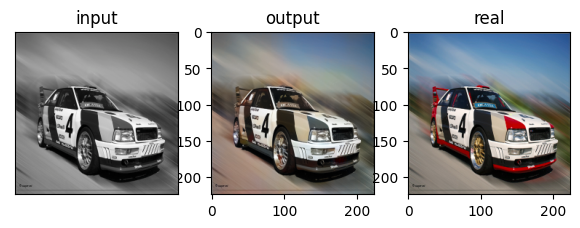

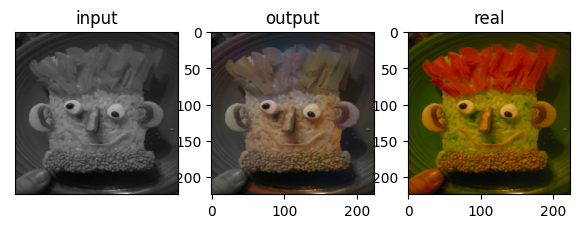

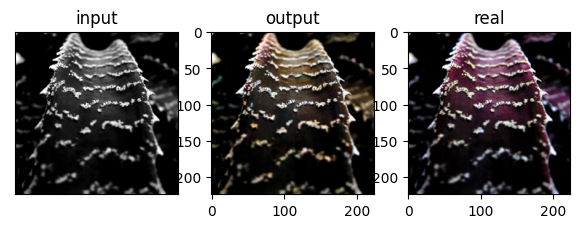

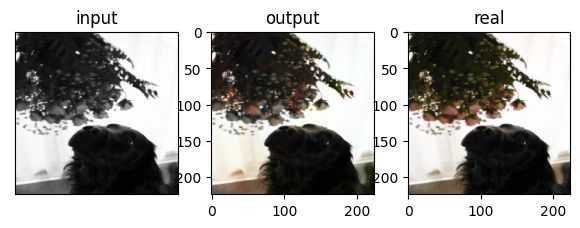

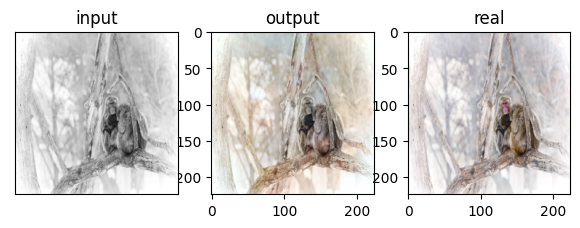

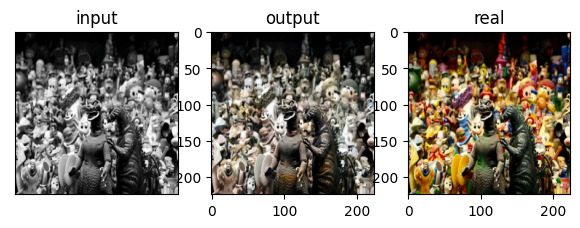

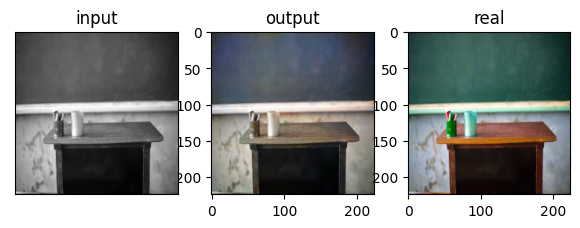

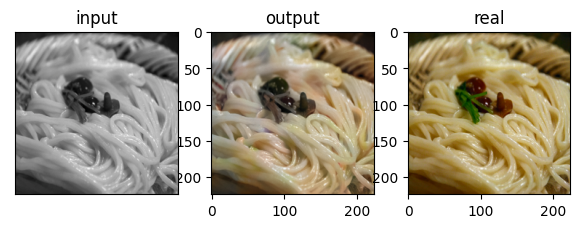

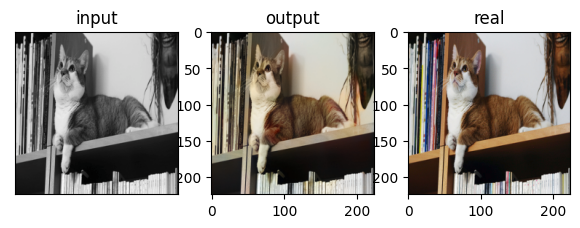

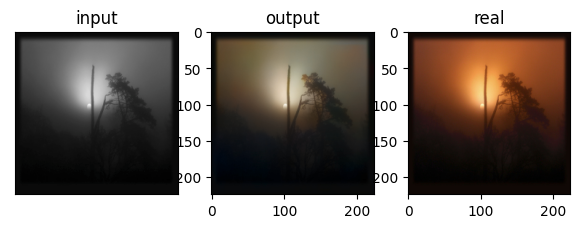

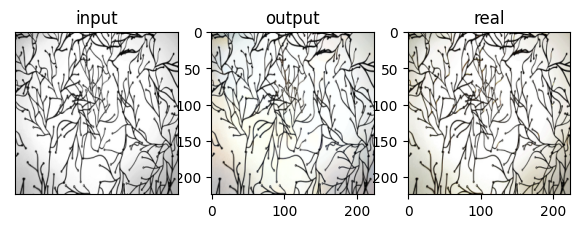

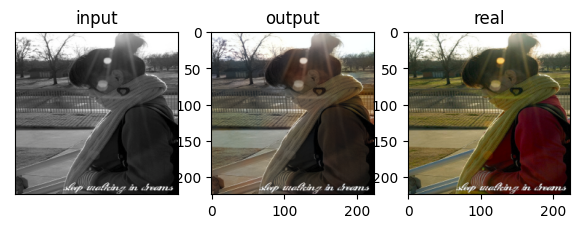

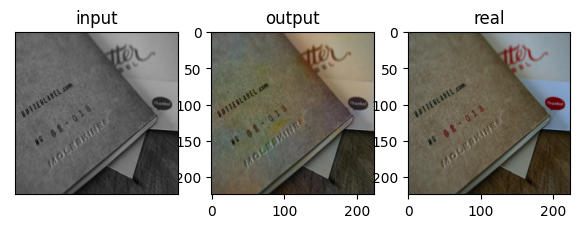

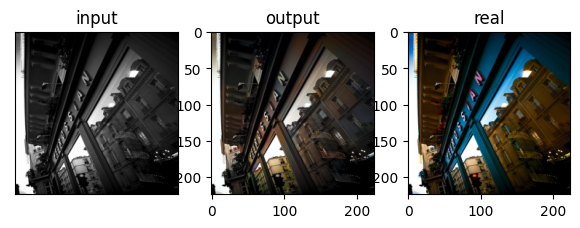

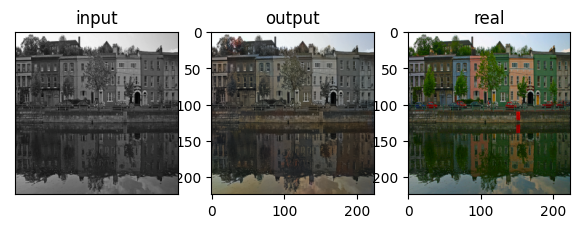

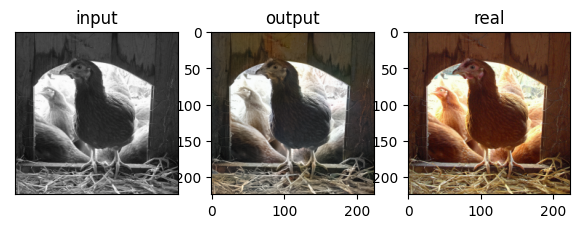

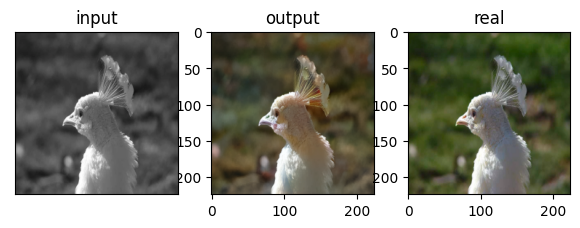

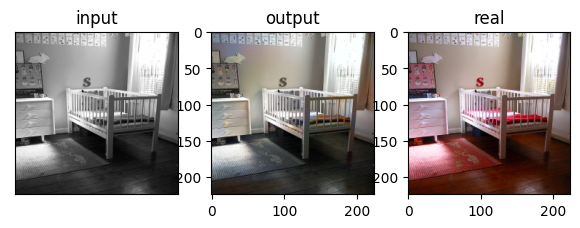

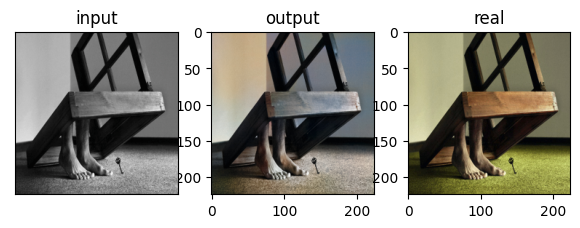

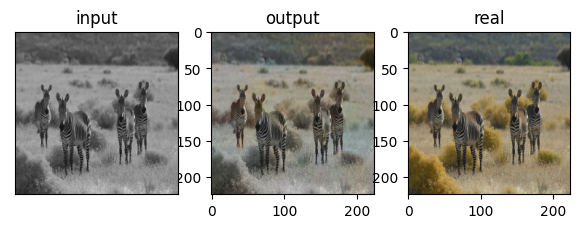

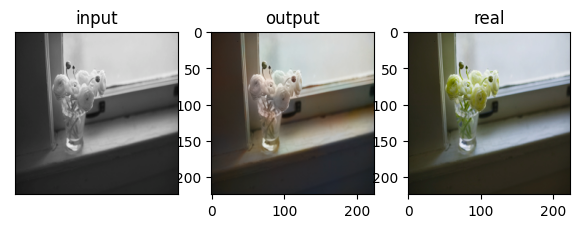

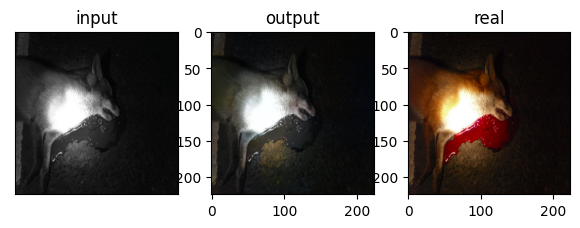

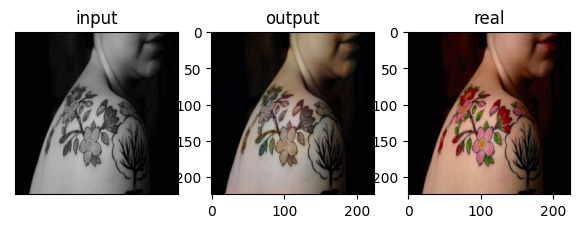

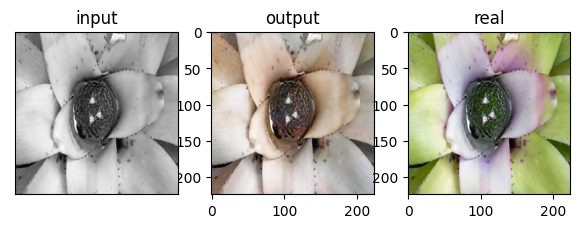

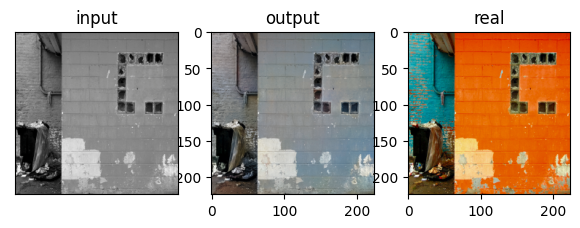

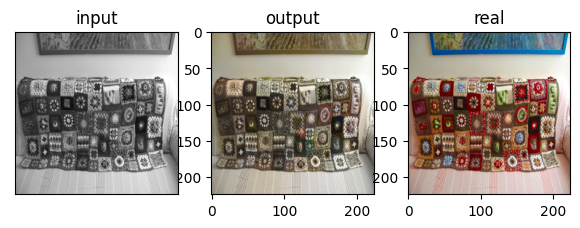

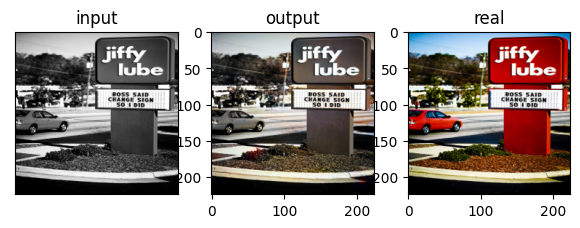

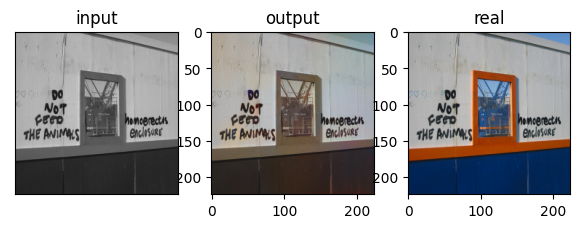

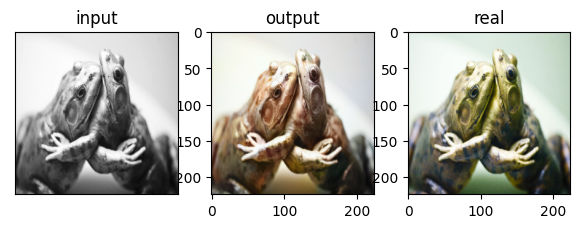

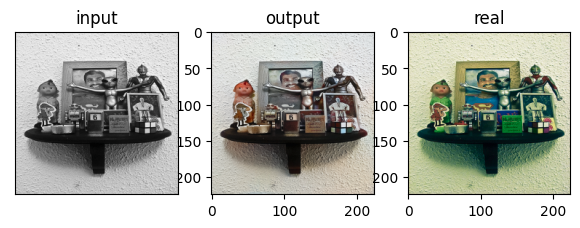

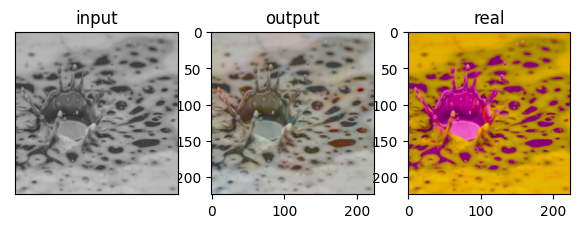

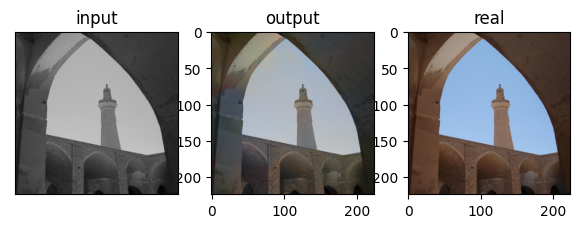

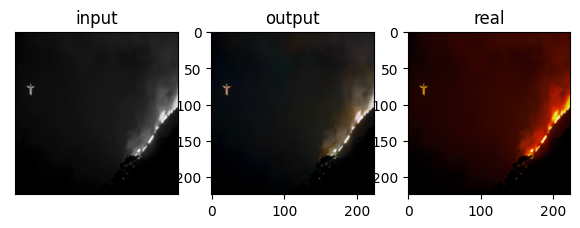

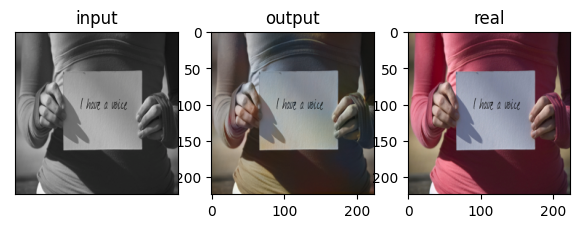

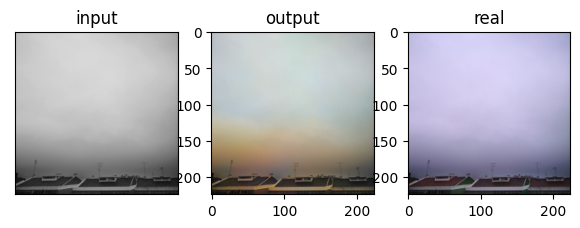

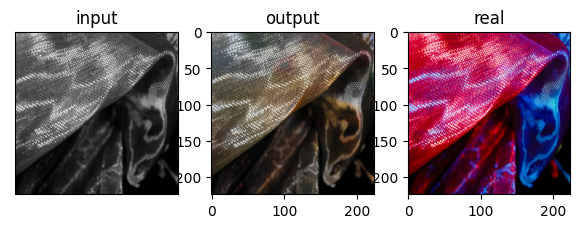

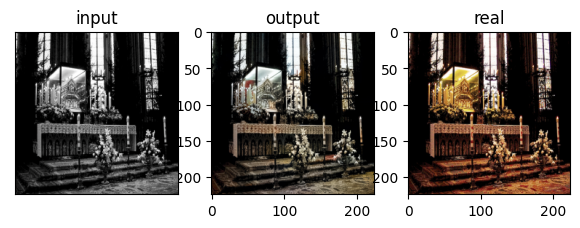

ValueError: num must be 1 <= num <= 144, not 146

<Figure size 3000x3000 with 0 Axes>

In [6]:
model = ColorizationModel()
checkpoint = torch.load('/kaggle/input/model40h/colorization_model_17.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
test_loader = DataLoader(test_dataset, batch_size=1)
model.eval()
loop=0
i=1
with torch.no_grad():
    for L, AB in test_loader:
        loop = loop +1
        if loop < 20:
            continue
#         print(AB.shape)
        # Forward pass
        outputs = model(L)
        output_image = np.zeros((224, 224, 3))
        output_image[:, :, 1:] = outputs.numpy().squeeze().transpose((1, 2, 0))      
        output_image[:, :, 0] = L.numpy().squeeze()
        output_image = ((output_image+1)*127.5).astype(np.uint8)
        
        intput_image = np.zeros((224, 224, 3))
        intput_image[:, :, 0] = L.numpy().squeeze()
        intput_image[:, :, 1:] = AB.numpy().squeeze().transpose((1, 2, 0))
        intput_image = ((intput_image+1)*127.5).astype(np.uint8)
        intput_image = cv2.cvtColor(intput_image, cv2.COLOR_LAB2RGB)

        # Convert output to RGB color space
        output_image = cv2.cvtColor(output_image, cv2.COLOR_LAB2RGB)
        
        
        plt.figure(figsize=(30,30))
        plt.subplot(12,12,i+1)
        plt.title('output')
        plt.imshow(output_image)
        plt.subplot(12,12,i+2)
        plt.title('real')
        plt.imshow(intput_image)

#         plt.imshow(output_image, interpolation = 'bicubic')
        
        lab_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2LAB)
        Li, Ai, Bi = cv2.split(lab_image)
#         Li.fill(255)
        Ai.fill(128)
        Bi.fill(128)
        image_lab = cv2.merge([Li, Ai, Bi])

        # Convert back to RGB color space if needed
        image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
        
        plt.subplot(12,12,i)
        plt.title('input')
        plt.imshow(image_rgb)
        i=i+3
        # Check the size of L, A, B channels
        plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
        plt.show()
